# **Sistema di raccomandazioni di film**

Laurea Magistrale in Informatica - Alma Mater Studiorum, **Università di Bologna**

Nome del gruppo: AHI-AHI-AHI
Indirizzo e-mail del referente: aurora.brega@studio.unibo.it
Componenti:
*   Francesco Saverio Beccafichi (matr: 0001052139)
*   Aurora Brega (matr: 0001046055)
*   Francesco Piconi (matr: 0001054500)

**INSTALLAZIONE DELLE LIBRERIE NECESSARIE**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
pip install surprise numpy pandas matplotlib nltk sklearn 


**IMPORT DELLE LIBRERIE NECESSARIE**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import difflib

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from ast import literal_eval
from surprise import SVD,accuracy, Reader, Dataset,SVDpp
from surprise.model_selection import train_test_split,GridSearchCV
from surprise.model_selection import cross_validate,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from collections import defaultdict


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

**IMPORT DEL DATASET**

In [ ]:
film=pd.read_csv('archive/movies_metadata.csv')
links_small = pd.read_csv('archive/links_small.csv')
credits = pd.read_csv('archive/credits.csv')
keywords = pd.read_csv('archive/keywords.csv')
ratings = pd.read_csv('archive/ratings_small.csv')

**Estrazione dei generi e l'anno di produzione dal dataset**

In [6]:
film['genres'] = film['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [7]:
film['year'] = pd.to_datetime(film['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# **Sistema basato sulla popolarità**

In [8]:
num_voti = film[film['vote_count'].notnull()]['vote_count'].astype('int')
media_voto = film[film['vote_average'].notnull()]['vote_average'].astype('int')
C = media_voto.mean()
C

5.244896612406511

In [9]:
m = num_voti.quantile(0.95)
m

434.0

In [10]:
film_popolari = film[(film['vote_count'] >= m) & (film['vote_count'].notnull()) & (film['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
film_popolari['vote_count'] = film_popolari['vote_count'].astype('int')
film_popolari['vote_average'] = film_popolari['vote_average'].astype('int')
film_popolari.shape
film_popolari

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


**Calcolo del weighted rating per ordinare i film in base al voto medio**

In [11]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [12]:
film_popolari['wr'] = film_popolari.apply(weighted_rating, axis=1)

In [13]:
film_popolari = film_popolari.sort_values('wr', ascending=False).head(250)

In [14]:
film_popolari.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


# **Sistema basato sulla similarità dei contenuti**
Vengono estratti i valori del genere, degi attori, del regista, e delle parole chiave che descrivono il film, per calcolare la similarità cosenica con gli altri film della collezione

In [15]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small
links_small.index = np.arange(1,len(links_small)+1)

In [16]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [17]:
film['id'] = film['id'].apply(convert_int)
film.dropna(subset=['id'],inplace=True)

In [18]:
film['id'] = film['id'].astype('int')

In [19]:
film_meta = film[film['id'].isin(links_small)]
film_meta.shape
film_meta.drop_duplicates(subset=['id'], keep='first', inplace=True)
film_meta.shape

(9082, 25)

In [20]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
film['id'] = film['id'].astype('int')

In [21]:
#merge dei film con le informazioni riguardo il cast e le keyword che lo descrivono
film = film.merge(credits, on='id')
film = film.merge(keywords, on='id')

In [22]:
film_meta = film[film['id'].isin(links_small)]
film_meta.shape
film_meta

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,Released,NaN,The Last Brickmaker in America,False,7.0,1.0,2001,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...","[{'id': 6054, 'name': 'friendship'}, {'id': 20..."
41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,Released,Decorated Officer. Devoted Family Man. Defendi...,Rustom,False,7.3,25.0,2016,"[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...","[{'id': 10540, 'name': 'bollywood'}]"
41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,Released,NaN,Mohenjo Daro,False,6.7,26.0,2016,"[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...","[{'id': 10540, 'name': 'bollywood'}]"
41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,"[{'cast_id': 4, 'character': 'Rando Yaguchi : ...","[{'credit_id': '560892fa92514177550018b2', 'de...","[{'id': 1299, 'name': 'monster'}, {'id': 7671,..."


In [23]:
film_meta['cast']=film_meta['cast'].apply(literal_eval)
film_meta['crew'] = film_meta['crew'].apply(literal_eval)
film_meta['keywords'] = film_meta['keywords'].apply(literal_eval)
film_meta['cast_size'] = film_meta['cast'].apply(lambda x: len(x))
film_meta['crew_size'] = film_meta['crew'].apply(lambda x: len(x))


In [24]:
#funzione per estratte il regista dalla crew
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [25]:
film_meta['director'] = film_meta['crew'].apply(get_director)

In [26]:
film_meta['cast'] = film_meta['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
film_meta['cast'] = film_meta['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [27]:
film_meta['keywords'] = film_meta['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [28]:
film_meta['cast'] = film_meta['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [29]:
film_meta['director'] = film_meta['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
film_meta['director'] = film_meta['director'].apply(lambda x: [x,x])

In [30]:
film_meta

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,False,7.0,1.0,2001,"[sidneypoitier, wendycrewson, jayo.sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...","[friendship, brick making]",7,2,"[greggchampion, greggchampion]"
41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,False,7.3,25.0,2016,"[akshaykumar, ileanad'cruz, eshagupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",[bollywood],14,16,"[tinusureshdesai, tinusureshdesai]"
41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,False,6.7,26.0,2016,"[hrithikroshan, poojahegde, kabirbedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",[bollywood],12,16,"[ashutoshgowariker, ashutoshgowariker]"
41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,False,6.6,152.0,2016,"[hirokihasegawa, yutakatakenouchi, satomiishih...","[{'credit_id': '560892fa92514177550018b2', 'de...","[monster, godzilla, giant monster, destruction...",49,27,"[hideakianno, hideakianno]"


In [31]:
s = film_meta.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s

C:\Users\franc\AppData\Local\Temp\ipykernel_6320\4103144304.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = film_meta.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


0           jealousy
0                toy
0                boy
0         friendship
0            friends
            ...     
41391    destruction
41391          kaiju
41391          toyko
41669          music
41669    documentary
Name: keyword, Length: 64407, dtype: object

In [32]:
s = s.value_counts()
s[:5]
s = s[s > 1]

**Calcolo similarità cosenica tra film**

In [33]:
stemmer = SnowballStemmer('english')

In [34]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [35]:
#preparazione delle keyword con lo stemming per le successive analisi
film_meta['keywords'] = film_meta['keywords'].apply(filter_keywords)
film_meta['keywords'] = film_meta['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
film_meta['keywords'] = film_meta['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [36]:
#scelta delle features da considerare per ogni film
film_meta['soup'] = film_meta['keywords'] + film_meta['cast'] + film_meta['director'] + film_meta['genres']
film_meta['soup'] = film_meta['soup'].apply(lambda x: ' '.join(x))

In [37]:
count = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(film_meta['soup'])

In [38]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [39]:
film_meta = film_meta.reset_index()
titles = film_meta['title']
indices = pd.Series(film_meta.index, index=film_meta['title'])

In [40]:
#funzione che prende in input il titolo di un film e ne restituisce i più simili ordinati in base al voto medio espresso dagli utenti 
def raccomandazione_metadati(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = film_meta.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    num_voti = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    media_voto = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = media_voto.mean()
    m = num_voti.quantile(0.6)
    film_popolari = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    film_popolari['vote_count'] = film_popolari['vote_count'].astype('int')
    film_popolari['vote_average'] = film_popolari['vote_average'].astype('int')
    film_popolari['wr'] = film_popolari.apply(weighted_rating, axis=1)
    film_popolari = film_popolari.sort_values('wr', ascending=False).head(25)
    return film_popolari

In [41]:
raccomandazione_metadati('The Dark Knight').head(25)

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
7583,Kick-Ass,4747,7,2010,6.852979
8419,Man of Steel,6462,6,2013,5.952478
8467,Kick-Ass 2,2275,6,2013,5.879027
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943


# **Applicazione sistema per consigliare un film ad un certo utente utilizzando i metadati dei film che ha apprezzato**


In [42]:
film_meta.shape

(9219, 33)

In [43]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [44]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [45]:
#Per andare a collegare i file contenenti le valutazioni degli utenti e i dati relativi ad ogni film
#viene utilizzato il il dataframe links_small che associa ad ogni movieId i relativi metadati
id_map =  pd.read_csv('archive/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(film_meta[['title', 'id','genres']], on='id')
id_map

,movieId,id,title,genres
0,1,862.0,Toy Story,"[Animation, Comedy, Family]"
1,2,8844.0,Jumanji,"[Adventure, Fantasy, Family]"
2,3,15602.0,Grumpier Old Men,"[Romance, Comedy]"
3,4,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,11862.0,Father of the Bride Part II,[Comedy]
...,...,...,...,...
9214,161944,159550.0,The Last Brickmaker in America,[Drama]
9215,162542,392572.0,Rustom,"[Thriller, Romance]"
9216,162672,402672.0,Mohenjo Daro,"[Adventure, Drama, History, Romance]"
9217,163056,315011.0,Shin Godzilla,"[Action, Adventure, Drama, Horror, Science Fic..."


In [46]:
indices_map = id_map.set_index('id')
indices_map

,movieId,title,genres
id,,,
862.0,1,Toy Story,"[Animation, Comedy, Family]"
8844.0,2,Jumanji,"[Adventure, Fantasy, Family]"
15602.0,3,Grumpier Old Men,"[Romance, Comedy]"
31357.0,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
11862.0,5,Father of the Bride Part II,[Comedy]
...,...,...,...
159550.0,161944,The Last Brickmaker in America,[Drama]
392572.0,162542,Rustom,"[Thriller, Romance]"
402672.0,162672,Mohenjo Daro,"[Adventure, Drama, History, Romance]"


In [47]:
#Funzione per trovare i film recensiti da un utente
def get_movies_watched_by(userID):
 user_filter = ratings['userId'] == userID 
 movies_watched = ratings[user_filter]
 filter = movies_watched['rating'] > 3
 movies_watched= movies_watched[filter]
 return movies_watched

In [48]:
#Funzione per generare delle raccomandazioni per un utente in base ai film che ha valuato positivamente. 
#Verranno quindi consigliati dei film simili a quelli cha ha già valutato.
def get_movie_recommendations_for(userID):
 movies_watched = get_movies_watched_by(userID)
 similar_movies = []
 for index, row in movies_watched.iterrows():
    sim_movies = list(enumerate(cosine_sim[index]))
    sim_movies_sorted = sorted(sim_movies, key=lambda movieid_score_tuple: movieid_score_tuple[1], reverse=True)
    similar_movies = similar_movies + sim_movies_sorted[1:8]

 similar_movies = sorted(similar_movies, key=lambda movieid_score_tuple: movieid_score_tuple[1], reverse=True)
 top_10_recommendations = similar_movies
 results_2 = list()
 for movie_score in top_10_recommendations:
    movie_index = movie_score[0]
    movie_score = movie_score[1]
    t = (userID, movie_index, movie_score)
    results_2.append(t)
 return results_2


In [49]:
results = get_movie_recommendations_for(25)
resu=pd.DataFrame(results,columns=['userID','movie_index', 'score'])

fil=film_meta[['id','title','genres']]

f=pd.merge(resu,id_map,how='inner',left_on='movie_index',right_on='movieId')
f.drop_duplicates(subset=['movie_index'], keep='first', inplace=True)
f.drop(['movie_index','id',], axis=1, inplace=True)
display(f.head(10))

,userID,score,movieId,title,genres
0,25,0.337396,523,Ruby in Paradise,"[Drama, Romance]"
1,25,0.307564,3852,The Tao of Steve,"[Comedy, Romance]"
2,25,0.302981,1378,Young Guns,"[Crime, Action, Adventure, Drama, Western]"
3,25,0.279985,5732,Eye of the Needle,"[Action, Drama, Romance, Thriller]"
4,25,0.257135,6027,Dogfight,"[War, Drama, Romance]"
5,25,0.235413,6762,Yossi & Jagger,"[War, Drama, Romance]"
6,25,0.224954,3342,Birdy,"[Drama, History]"
7,25,0.203627,2714,The Wood,"[Comedy, Drama, Romance]"
8,25,0.195624,4679,Uncle Buck,"[Comedy, Drama, Family]"
9,25,0.193625,2382,Police Academy 5: Assignment Miami Beach,"[Comedy, Crime]"


# **Sistema di filtraggio collaborativo**
Utilizzare le recensioni degli utenti nel dataframe ratings per consigliare dei film ad uno specifico utente

In [50]:
#Split dei dati tra train e test
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)

In [51]:
#Addestramento modello SVD
svd=SVD()

svd.fit(trainset)
prediction = svd.test(testset)

# Calcolo RMSE e MAE
display(accuracy.rmse(prediction))
display(accuracy.mae(prediction))

RMSE: 0.8998


0.8997598593034548

MAE:  0.6920


0.6919755368509671

In [52]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8981  0.9055  0.8883  0.8976  0.8944  0.8968  0.0056  
MAE (testset)     0.6919  0.6952  0.6853  0.6898  0.6860  0.6896  0.0037  
Fit time          0.98    0.95    1.13    1.04    1.41    1.10    0.17    
Test time         0.26    0.22    0.20    0.34    0.23    0.25    0.05    


{'test_rmse': array([0.89808237, 0.90546217, 0.88831171, 0.8975781 , 0.89439479]),
 'test_mae': array([0.69192365, 0.6952228 , 0.6852887 , 0.68976251, 0.68603315]),
 'fit_time': (0.9793703556060791,
  0.9455289840698242,
  1.1260197162628174,
  1.0371739864349365,
  1.4132142066955566),
 'test_time': (0.25531673431396484,
  0.22135019302368164,
  0.20444154739379883,
  0.34307861328125,
  0.23138070106506348)}

RMSE: 0.8836
RMSE: 0.8859
RMSE: 0.8817
RMSE: 0.8831
RMSE: 0.8813
RMSE: 0.8794
RMSE: 0.8806
RMSE: 0.8777


Text(0.5, 1.0, 'RMSE vs Factors')

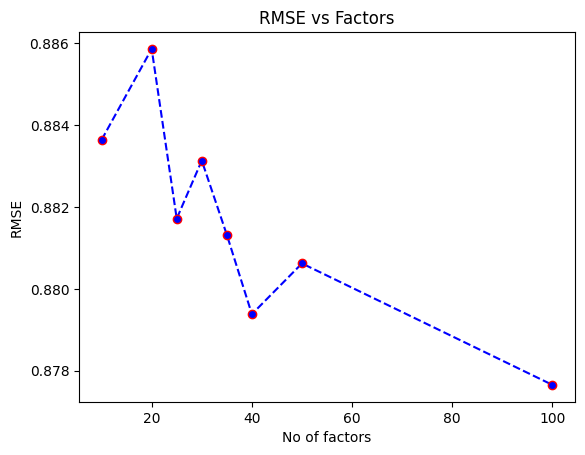

In [53]:
#Factors vs RMSE
validationset = trainset.build_testset()
training_rmse = []
testing_rmse =[]
number_of_factors_list = [10,20,25,30,35,40,50,100]
for factor in number_of_factors_list:
 model = SVD(n_factors=factor,n_epochs=50,lr_all=0.01,reg_all=0.1)
 model.fit(trainset)
 test_predictions = model.test(testset)
 testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(0)
plt.plot(number_of_factors_list,testing_rmse, 'b.--', markersize=12, markeredgecolor='r')
plt.xlabel('No of factors')
plt.ylabel('RMSE')
plt.title("RMSE vs Factors")

RMSE: 0.8934
RMSE: 0.8869
RMSE: 0.8807
RMSE: 0.8786
RMSE: 0.8775


Text(0.5, 1.0, 'RMSE vs Epochs')

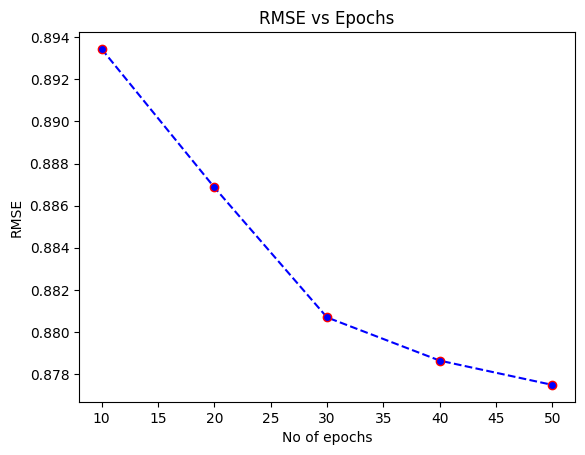

In [54]:
#Epochs vs RMSE
training_rmse = []
testing_rmse =[]
number_of_epochs_list = [10,20,30,40,50]
for epoch in number_of_epochs_list:
 model = SVD(n_factors=100,n_epochs=epoch,lr_all=0.01,reg_all=0.1)
 model.fit(trainset)
 test_predictions = model.test(testset)
 testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(1)
plt.plot(number_of_epochs_list,testing_rmse, 'b.--', markersize=12,markeredgecolor='r')
plt.xlabel('No of epochs')
plt.ylabel('RMSE')
plt.title("RMSE vs Epochs")



RMSE: 1.0618
RMSE: 1.0669
RMSE: 0.8365
RMSE: 0.9022
RMSE: 0.5688
RMSE: 0.8784
RMSE: 0.5526
RMSE: 0.8785
RMSE: 0.4883
RMSE: 0.8980
RMSE: 0.4988
RMSE: 0.9016


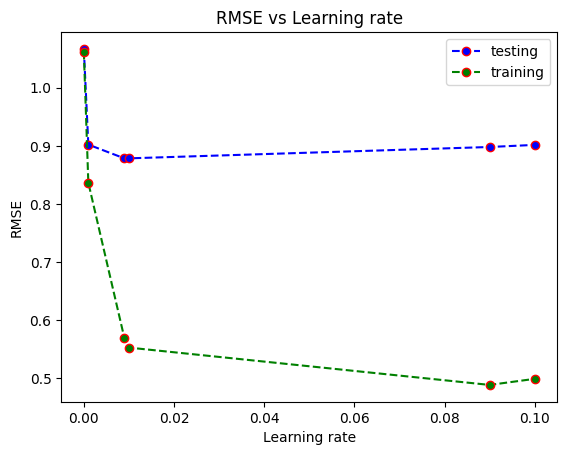

In [55]:
#Learning rate rispetto a RMSE
training_rmse = []
testing_rmse =[]
learning_rate_list = [0,0.001,0.009,0.01,0.09,0.1]
for lr in learning_rate_list:
 model = SVD(n_factors=100,n_epochs=50,lr_all=lr,reg_all=0.1)
 model.fit(trainset)
 training_predictions = model.test(validationset)
 training_rmse.append(accuracy.rmse(training_predictions))
 test_predictions = model.test(testset)
 testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(2)
plt.plot(learning_rate_list,testing_rmse, 'b.--', markersize=12,markeredgecolor='r',label='testing')
plt.plot(learning_rate_list,training_rmse, 'g.--', markersize=12,markeredgecolor='r',label='training')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.title("RMSE vs Learning rate")
plt.legend()


RMSE: 0.0792
RMSE: 0.9999
RMSE: 0.0825
RMSE: 0.9807
RMSE: 0.1209
RMSE: 0.9354
RMSE: 0.1260
RMSE: 0.9368
RMSE: 0.5137
RMSE: 0.8792
RMSE: 0.5529
RMSE: 0.8796


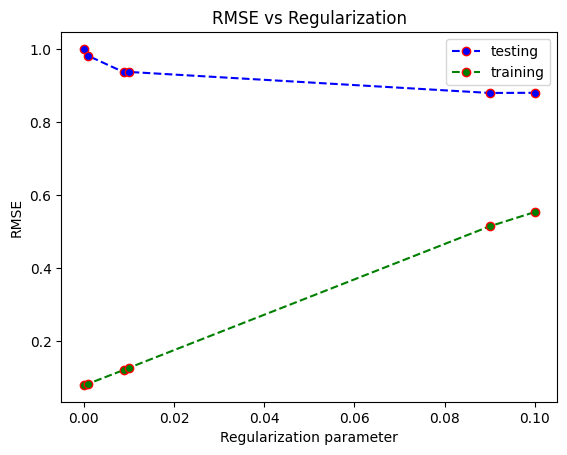

In [56]:
#Regularization parameter vs RMSE

training_rmse = []
testing_rmse =[]
regularization_parameter_list = [0,0.001,0.009,0.01,0.09,0.1]
for reg in regularization_parameter_list:
 model = SVD(n_factors=100,n_epochs=50,lr_all=0.01,reg_all=reg)
 model.fit(trainset)
 training_predictions = model.test(validationset)
 training_rmse.append(accuracy.rmse(training_predictions))
 test_predictions = model.test(testset)
 testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(3)
plt.plot(regularization_parameter_list,testing_rmse, 'b.--',markersize=12, markeredgecolor='r',label='testing')
plt.plot(regularization_parameter_list,training_rmse, 'g.--',markersize=12, markeredgecolor='r',label='training')
plt.xlabel('Regularization parameter')
plt.ylabel('RMSE')
plt.title("RMSE vs Regularization")
plt.legend()


In [61]:
#Gridsearch per trovare i miglior hyperparametri
number_of_factors_list = [10,20,25,30,35,40,50,100]
number_of_epochs_list = [10,20,30,40,50]
learning_rate_list = [0.9,0.09,0.009,0.1,0.01,0.001]
regularization_parameter_list = [0.9,0.09,0.009,0.1,0.01,0.001]
hyper_parameters_set = { 'n_factors': number_of_factors_list,'n_epochs': number_of_epochs_list, 'lr_all':learning_rate_list,'reg_all': regularization_parameter_list}
trained_model = SVD
best_model_selection = GridSearchCV(trained_model,hyper_parameters_set,measures=['rmse'],cv=4)
best_model_selection.fit(data)
print("Migliori parametri:",best_model_selection.best_params['rmse'])

In [ ]:
#Modello con i miglior hyperparametri
svdtuned = SVD(n_factors=100,n_epochs=50,lr_all=0.01,reg_all=0.1)
svdtuned.fit(trainset)
predictio = svdtuned.test(testset)
display(accuracy.rmse(predictio))
display(accuracy.mae(predictio))

RMSE: 0.8739


0.8738533908037057

MAE:  0.6720


0.6720159047754602

In [ ]:
#Modello SVDpp
svdpp=SVDpp()

svdpp.fit(trainset)
predictions = svdpp.test(testset)

display(accuracy.rmse(predictions))
display(accuracy.mae(predictions))


RMSE: 0.8860


0.8860212995221466

MAE:  0.6803


0.6803487460815921

In [ ]:
#Funzione per generare raccomandazioni per un certo utente attraverso uno dei modelli creati
def recomm_svd(userId,modello):
    movies = film_meta[['id','title', 'vote_average','genres']]
    movies['genres']=movies["genres"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
    movies['est'] = movies['id'].apply(lambda x: modello.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    movies.drop('id', axis=1, inplace=True)
    return movies.head(10)

In [ ]:
display(recomm_svd(25,svd))
display(recomm_svd(25,svdtuned))
display(recomm_svd(25,svdpp))

,title,vote_average,genres,est
731,Singin' in the Rain,7.9,"Comedy,Music,Romance",4.188874
284,The Shawshank Redemption,8.5,"Drama,Crime",4.134203
1524,On the Waterfront,8.0,"Crime,Drama",4.102156
48,The Usual Suspects,8.1,"Drama,Crime,Thriller",4.084207
2401,Crimes and Misdemeanors,7.4,"Comedy,Drama",4.066669
631,Dr. Strangelove or: How I Learned to Stop Worr...,8.0,"Drama,Comedy,War",4.064242
1641,Roger & Me,7.4,"Documentary,History",4.059332
740,North by Northwest,7.8,"Mystery,Thriller",4.056457
1023,Chinatown,7.9,"Crime,Drama,Mystery,Thriller",4.053647
797,The African Queen,7.4,"Adventure,War,Romance",4.040143


,title,vote_average,genres,est
990,Ran,7.9,"Action,Drama,History",4.226229
128,Amateur,6.5,"Crime,Comedy,Drama,Thriller",4.200256
7786,The Play House,6.9,"Comedy,Fantasy",4.170198
5714,Love Me If You Dare,7.4,"Drama,Comedy,Romance",4.160563
6759,21 Up,7.9,"Documentary,Foreign",4.158667
2362,Drunken Master,7.2,"Action,Comedy",4.157471
1524,On the Waterfront,8.0,"Crime,Drama",4.152123
2457,A Face in the Crowd,7.4,Drama,4.149054
5938,Gummo,6.5,Drama,4.142975
7500,Hachi: A Dog's Tale,7.7,"Drama,Family",4.142930


,title,vote_average,genres,est
627,A Close Shave,7.5,"Family,Animation,Comedy",4.032144
2055,"Lock, Stock and Two Smoking Barrels",7.5,"Comedy,Crime",4.003855
284,The Shawshank Redemption,8.5,"Drama,Crime",4.003024
796,Night of the Living Dead,7.5,Horror,4.000776
2454,Mister Roberts,7.3,"Comedy,Drama,Family,War",3.978489
1047,Cool Hand Luke,7.7,"Crime,Drama",3.963264
757,All About Eve,8.0,Drama,3.956085
2780,Modern Times,8.1,"Drama,Comedy",3.955984
2304,American Beauty,7.9,Drama,3.939633
2171,Run Lola Run,7.2,"Action,Drama,Thriller",3.923132


In [ ]:
#Funzione per calcolare precision@k e recall@k
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls
    


{'topN': 5, 'Precision': 0.9076005961251866, 'Recall': 0.4220744557578549}

{'topN': 6, 'Precision': 0.9060606060606055, 'Recall': 0.47232942966160785}

{'topN': 7, 'Precision': 0.9002767724079185, 'Recall': 0.5110615132847351}

{'topN': 8, 'Precision': 0.8974558228656585, 'Recall': 0.5443250583419225}

{'topN': 9, 'Precision': 0.8955929316585065, 'Recall': 0.573308432483929}

{'topN': 10, 'Precision': 0.8945497125824985, 'Recall': 0.5992537983194555}

In [ ]:
#precision e recall di SVDpp
precision_recall_at_n = []
rating_threshold=3
for topn in range(2,20):
 precision, recall = precision_recall_at_k(predictions,topn,rating_threshold)
 precision_at_n = sum(prec for prec in precision.values()) / len(precision)
 recall_at_n = sum(rec for rec in recall.values()) / len(recall)
 precision_recall_at_n.append({'topN' : topn, 'Precision' : precision_at_n, 'Recall': recall_at_n})
for n in range(3,9):
 display(precision_recall_at_n[n])

In [ ]:
#precison e recall SVD normale
precision_recall_at_n = []
rating_threshold=3
for topn in range(2,20):
 precision, recall = precision_recall_at_k(prediction,topn,rating_threshold)
 precision_at_n = sum(prec for prec in precision.values()) / len(precision)
 recall_at_n = sum(rec for rec in recall.values()) / len(recall)
 precision_recall_at_n.append({'topN' : topn, 'Precision' : precision_at_n, 'Recall': recall_at_n})
for n in range(3,9):
 display(precision_recall_at_n[n])

{'topN': 5, 'Precision': 0.9105812220566324, 'Recall': 0.3570694238716743}

{'topN': 6, 'Precision': 0.9083954297069047, 'Recall': 0.404537763292297}

{'topN': 7, 'Precision': 0.9037825562415712, 'Recall': 0.44615727903288066}

{'topN': 8, 'Precision': 0.9025317578596265, 'Recall': 0.4840273849346416}

{'topN': 9, 'Precision': 0.9007723606084276, 'Recall': 0.5176989048813796}

{'topN': 10, 'Precision': 0.8989508669836528, 'Recall': 0.5460078082864926}

In [ ]:
#precison e recall SVD con i miglior hyperparametri
precision_recall_at_n = []
rating_threshold=3
for topn in range(2,20):
 precision, recall = precision_recall_at_k(predictio,topn,rating_threshold)
 precision_at_n = sum(prec for prec in precision.values()) / len(precision)
 recall_at_n = sum(rec for rec in recall.values()) / len(recall)
 precision_recall_at_n.append({'topN' : topn, 'Precision' : precision_at_n, 'Recall': recall_at_n})
for n in range(3,9):
 display(precision_recall_at_n[n])

{'topN': 5, 'Precision': 0.9167163437655242, 'Recall': 0.35861547052238885}

{'topN': 6, 'Precision': 0.913636363636363, 'Recall': 0.40812009698465607}

{'topN': 7, 'Precision': 0.909236392023276, 'Recall': 0.45035385137643785}

{'topN': 8, 'Precision': 0.9080388191043922, 'Recall': 0.4882789241110791}

{'topN': 9, 'Precision': 0.9077697348189165, 'Recall': 0.5216717440149471}

{'topN': 10, 'Precision': 0.9064781302486208, 'Recall': 0.5499766114020529}